In [10]:
%load_ext autoreload
%autoreload 2

Default GPU Device: /device:GPU:0


2023-12-18 22:40:08.368410: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-18 22:40:08.368610: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-18 22:40:08.368756: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-18 22:40:08.369596: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-18 22:40:08.369760: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-18 22:40:08.369900: I tensorflow/compiler

In [16]:
import numpy as np
from train import HomographyModel
import matplotlib.pyplot as plt
import cv2


In [148]:
model = HomographyModel(input_shape=(320, 320, 3))

model.load_model("./homography_checkpoints/best_ckpt.hdf5")

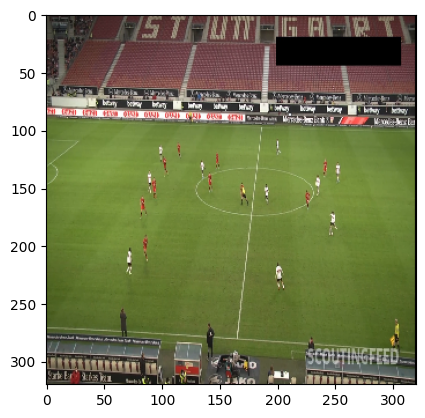

In [150]:
img = cv2.cvtColor(cv2.imread('../../images/frame.png'), cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (320,320))
plt.imshow(img)

In [151]:
res = model('../../images/frame.png')
res = res.astype(np.float64)

1/1 [==============================] - 2s 2s/step


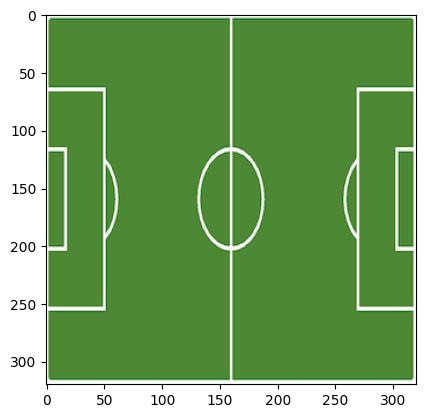

In [152]:
template = cv2.cvtColor(cv2.imread('./template.png'), cv2.COLOR_BGR2RGB)
# template = cv2.resize(template, (320,320))
plt.imshow(template)

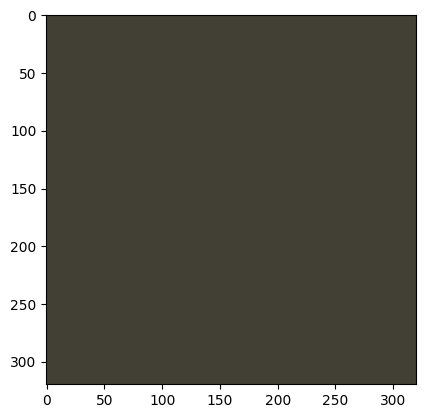

In [153]:
warped = cv2.warpPerspective(img, res[0], dsize=(320,320))
plt.imshow(warped)

## IMAGES FROM TRAIN

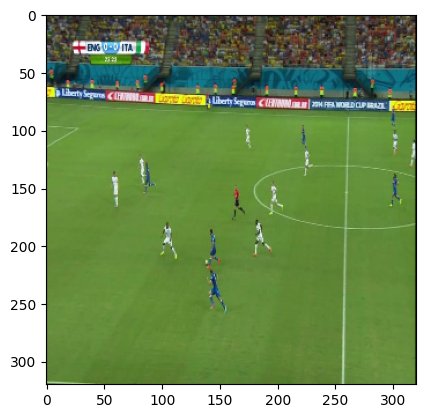

In [145]:
img_path = "/home/fer/Escritorio/futstatistics/datasets/narya/homography_dataset/dataset/train_img/0.jpg"
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (320,320))
plt.imshow(img)

In [164]:
H = np.load("/home/fer/Escritorio/futstatistics/datasets/narya/homography_dataset/dataset/train_homo/0_homo.npy")
H

array([[ 3.32257970e-01,  5.57784683e-04, -1.05540221e-01],
       [-9.27922205e-02,  1.55204300e+00,  4.58290388e-02],
       [-3.38531888e-02,  1.59596583e+00,  1.00000000e+00]])

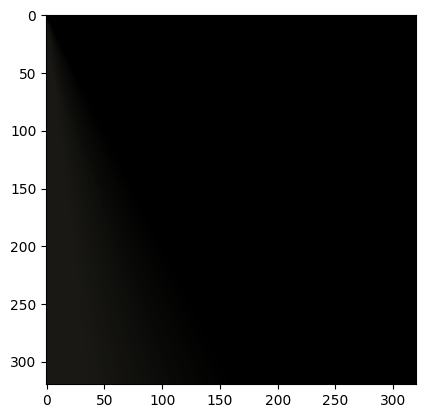

In [165]:
warped = cv2.warpPerspective(img, H, dsize=(320,320))
plt.imshow(warped)

In [162]:
import torch

def to_numpy(var):
    """Parse a Torch variable to a numpy array

    Arguments:
        var: torch variable
    Returns:
        a np.array with the same value as var
    Raises:
        
    """
    try:
        return var.numpy()
    except:
        return var.detach().numpy()


def to_torch(np_array):
    """Parse a numpy array to a torch variable

    Arguments:
        np_array: a np.array 
    Returns:
        a torch Var with the same value as the np_array
    Raises:
        
    """
    tensor = torch.from_numpy(np_array).float()
    return torch.autograd.Variable(tensor, requires_grad=False)
def get_four_corners(homo_mat):
    """Inverse operation of compute_homography. Gets the 4 corners from an homography.

    Arguments:
        homo_mat: Matrix of shape (B,3,3) or (3,3), homographies
    Returns:
        xy_warped: np.array of shape (B,4,2) with the corners
    Raises:
        ValueError: If the homographies are not of shape (3,3)
    """
    if isinstance(homo_mat, np.ndarray):
        homo_mat = to_torch(homo_mat)

    if homo_mat.shape == (3, 3):
        homo_mat = homo_mat[None]
    if homo_mat.shape[1:] != (3, 3):
        raise ValueError(
            "The shape of the homography is {}, not (3,3)".format(homo_mat.shape[1:])
        )

    canon4pts = to_torch(
        np.array([[-0.5, 0.1], [-0.5, 0.5], [0.5, 0.5], [0.5, 0.1]], dtype=np.float32)
    )

    assert canon4pts.shape == (4, 2)
    x, y = canon4pts[:, 0], canon4pts[:, 1]
    xy = torch.stack([x, y, torch.ones_like(x)])
    # warp points to model coordinates
    xy_warped = torch.matmul(homo_mat, xy)  # H.bmm(xy)
    xy_warped, z_warped = xy_warped.split(2, dim=1)
    xy_warped = xy_warped / (z_warped + 1e-8)
    xy_warped = to_numpy(xy_warped)
    return xy_warped

get_four_corners(H)